In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

from collections import Counter
from wordcloud import WordCloud
from PIL import Image

import nltk
from nltk.corpus import stopwords

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

In [492]:
# constants
DATA_PATH = '../data/'
COMPANY_PATH = DATA_PATH + 'companies/'
IMG_PATH = DATA_PATH + 'images/'

stop_words = set(stopwords.words('english'))

In [493]:
try:
    df = pd.read_pickle(COMPANY_PATH + 'monster-jobs.pickle')
except FileNotFoundError:
    df = pd.read_csv(COMPANY_PATH + 'us-companies.csv',encoding = 'ISO-8859-1')
    df.to_pickle(COMPANY_PATH + 'us-companies.pickle')

LENGTH = len(df)

In [494]:
cities = df['city']
states = df['state']
category = df['company_category']
co_type = df['company_type']
model = df['business_model']
size = df['full_time_employees']

In [495]:
'''
creates word cloud of locations mined from dataset
focuses on cities
'''
def make_US_word_cloud(locations):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    us_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="white", max_words=2000, mask=us_img,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'us-companies-city-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

'''
creates word cloud of locations mined from dataset
focuses on states
'''
def make_US_states_word_cloud(locations):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    #s_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="black", max_words=200,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'us-companies-state-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

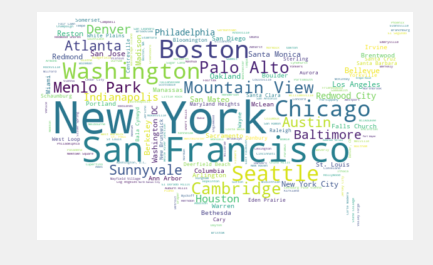

In [496]:
make_US_word_cloud(cities.value_counts().to_dict())

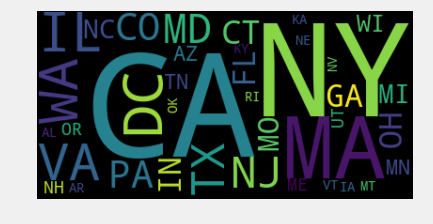

In [497]:
make_US_states_word_cloud(states.value_counts().to_dict())

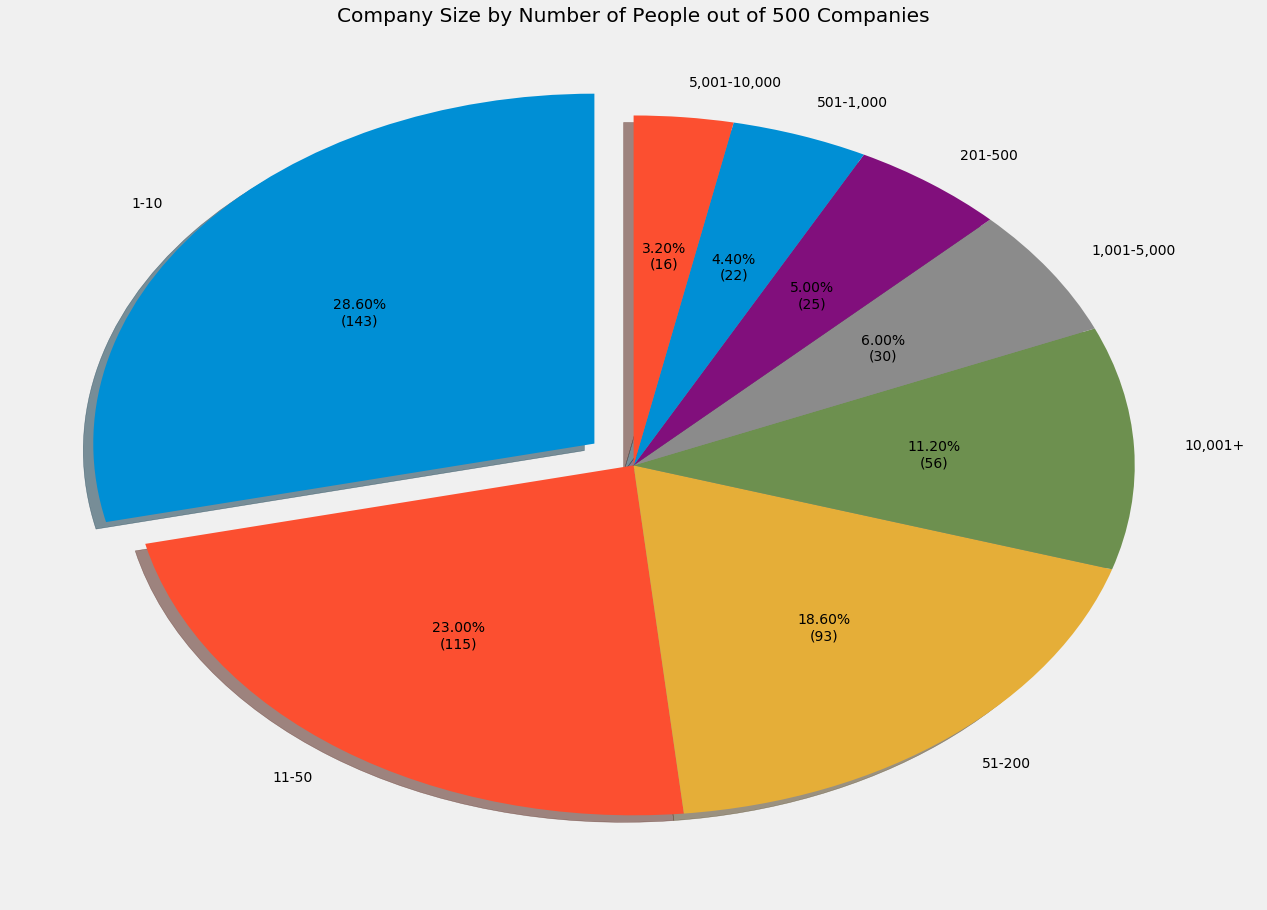

In [143]:
size_dict = size.value_counts().to_dict()

def make_autopct(values):
    def my_autopct(pct):
        sum = np.sum(values)
        val = int(round(pct*sum/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct
        

f, ax = plt.subplots(1,1, figsize=(20,15))
ax.pie(list(size_dict.values()), labels=list(size_dict.keys()), startangle=90, shadow=True, explode=(0.1,0,0,0,0,0,0,0), autopct=make_autopct(size_counts))
ax.set_title('Company Size by Number of People out of 500 Companies')
plt.show()

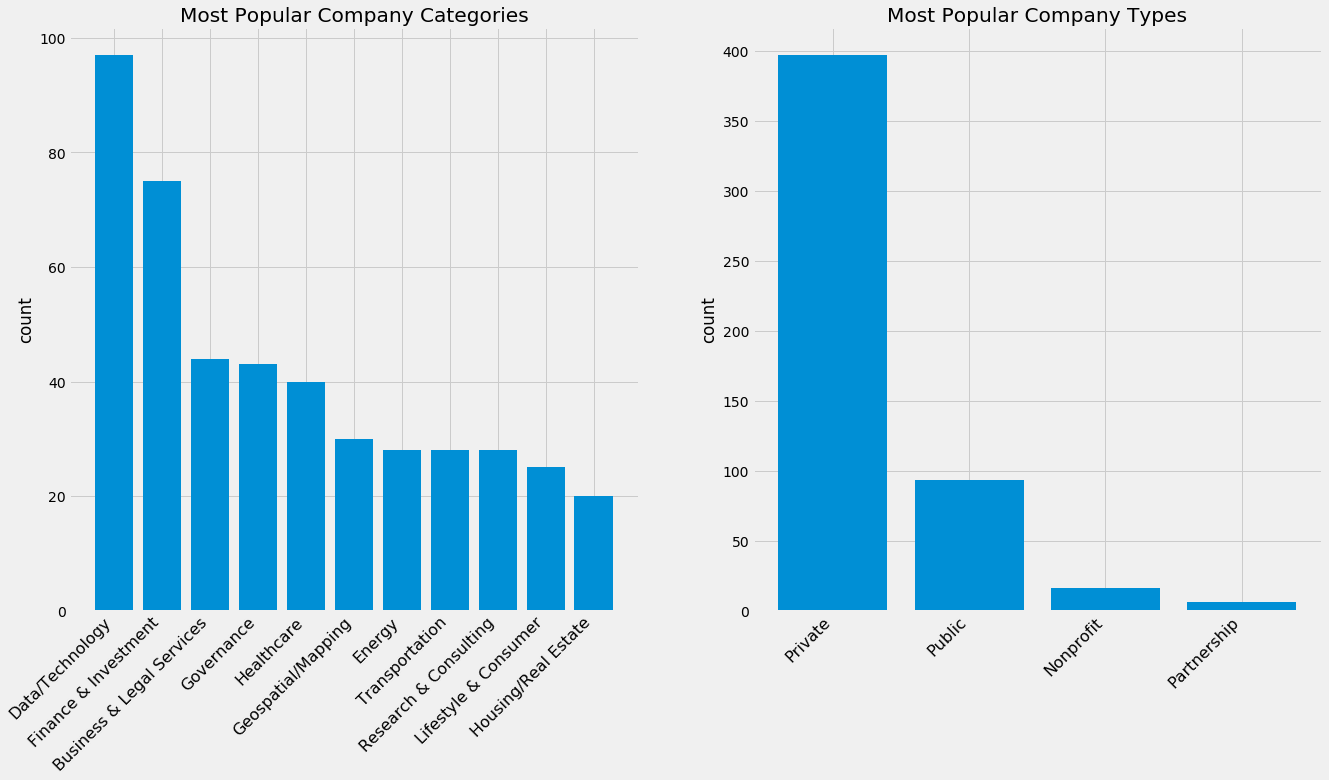

In [261]:
category_dict = category.value_counts().to_dict()
category_dict = {tup[0]:tup[1] for tup in Counter(category_dict).most_common(11)}

f, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.bar(range(len(category_dict)), category_dict.values(), align='center')
ax1.set_xticks(range(len(category_dict)))
ax1.set_xticklabels(category_dict.keys(), rotation=45, fontsize=16, ha='right')
ax1.set_title('Most Popular Company Categories')
ax1.set_ylabel('count')


co_type = co_type.replace(to_replace={'partnership':'Partnership','Public (Federal-USGS)':'Public','nonprofit + commercial spinoff':'Nonprofit', 'sole proprietorship':'Private', 'Private ':'Private', 'private':'Private'})
co_type_dict = co_type.value_counts().head(4).to_dict()

ax2.bar(range(len(co_type_dict)), co_type_dict.values(), align='center')
ax2.set_xticks(range(len(co_type_dict)))
ax2.set_xticklabels(co_type_dict.keys(), rotation=45, fontsize=16, ha='right')
ax2.set_title('Most Popular Company Types')
ax2.set_ylabel('count')
plt.show()

In [262]:

simplified_size = size.replace(to_replace={'1-10':'startup', '11-50':'startup',
                                          '51-200':'small', '201-500':'small',
                                          '501-1,000':'medium',
                                          '1,001-5,000':'medium',
                                          '5,001-10,000':'large',
                                          '10,001+':'large'})


In [263]:
size_dict = {'1-10':'startup', '11-50':'startup',
                                          '51-200':'small', '201-500':'small',
                                          '501-1,000':'medium',
                                          '1,001-5,000':'medium',
                                          '5,001-10,000':'large',
                                          '10,001+':'large'}
co_type_dict = {'partnership':'Partnership',
                'Public (Federal-USGS)':'Public',
                'nonprofit + commercial spinoff':'Nonprofit',
                'sole proprietorship':'Private', 
                'Private ':'Private', 
                'private':'Private'}

In [273]:
co_type.value_counts().head(4).to_dict().keys()

dict_keys(['Private', 'Public', 'Nonprofit', 'Partnership'])

In [400]:
from sklearn.preprocessing import LabelBinarizer
co_type_enc = LabelBinarizer()
co_type_enc.fit_transform(list(co_type.value_counts().head(4).to_dict().keys()))

state_enc = LabelBinarizer()
state_enc.fit_transform([key for key in states.value_counts().to_dict()])

size_enc = LabelBinarizer()
size_enc.fit_transform(list(set(size_dict.values())))


category_keys = list(category_dict.keys())
category_keys_dict = {category_keys[i]:i for i in range(len(category_keys))}

In [483]:

def make_featureset():
    featureset = []
    for _, row in df.iterrows():
        size = row['full_time_employees']
        co_type = row['company_type']
        state = row['state']
        category = row['company_category']
        features = []
        if ((not (pd.isnull(size) or pd.isnull(co_type) or pd.isnull(state) or pd.isnull(category))) and category in category_keys_dict):
            size = size_dict[size]
            if(co_type in co_type_dict):
                co_type = co_type_dict[co_type]
            
            enc_size = size_enc.transform([size])
            enc_co_type = co_type_enc.transform([co_type])
            enc_state = state_enc.transform([state])

            features.append(list(enc_size[0]))
            features.append(list(enc_co_type[0]))
            features.append(list(enc_state[0]))

            featureset.append([list(enc_size[0]), category_keys_dict[category]])
            #featureset.append([np.hstack(np.array(features)), category_keys_dict[category]])
    
    return featureset

def make_categorical_featureset():
    featureset = []
    for _, row in df.iterrows():
        size = row['full_time_employees']
        co_type = row['company_type']
        state = row['state']
        category = row['company_category']
        features = []
        if ((not (pd.isnull(size) or pd.isnull(co_type) or pd.isnull(state) or pd.isnull(category))) and category in category_keys_dict):
            size = size_dict[size]
            if(co_type in co_type_dict):
                co_type = co_type_dict[co_type]
            

            features.append(size)
            features.append(co_type)
            features.append(state)

            featureset.append([features, category_keys_dict[category]])
            #featureset.append([np.hstack(np.array(features)), category_keys_dict[category]])
    
    return featureset

In [484]:
#featureset = make_featureset()
featureset = make_categorical_featureset()

In [485]:
length = len(featureset)
split = int(.75 * length)

training = featureset[:split]
test = featureset[split:]

training = np.array(training)
test = np.array(test)

train_X = training[:,0]
train_y = training[:,1]


test_X = test[:,0]
test_y = test[:,1]


In [490]:
#MNB_classifier = SklearnClassifier(MultinomialNB())
#MNB_classifier.train(training)
#print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test))

#MNB_classifier = MultinomialNB()
#MNB_classifier.fit(list(train_X),list(train_y))
#MNB_classifier.score(list(test_X), list(test_y))

#MNB_classifier = MultinomialNB()
#MNB_classifier.fit(train_X,train_y)


In [467]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(list(train_X),list(train_y))

In [468]:
print(clf.predict(list(test_X)))

[0 8 0 0 0 1 8 8 0 0 0 0 0 8 1 1 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 1 0 0 0
 8 0 0 0 1 0 0 0 0 0 0 0 8 0 0 8 0 8 0 8 0 0 0 1 0 0 1 0 0 8 0 0 0 0 0 8 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 8 0 8 1 0 0 0 8 1 0 0 0 0 1 0 8 0 8 8 0 0]


In [470]:
test_y

array([0, 10, 6, 10, 9, 2, 0, 2, 3, 6, 3, 1, 7, 1, 0, 0, 0, 0, 3, 1, 6, 0,
       6, 1, 3, 0, 8, 0, 4, 9, 0, 6, 6, 1, 0, 4, 0, 0, 9, 3, 7, 1, 2, 7, 8,
       1, 0, 3, 10, 7, 4, 10, 0, 1, 5, 6, 8, 8, 4, 6, 1, 2, 1, 2, 0, 3, 2,
       4, 1, 7, 10, 9, 7, 7, 2, 5, 1, 2, 0, 0, 3, 4, 5, 3, 9, 6, 2, 1, 0,
       4, 9, 9, 7, 8, 0, 2, 6, 3, 0, 1, 9, 4, 9, 5, 10, 4, 10, 10], dtype=object)